##  Decoding Data Science Job Postings Notebook 3


This is a really tiny dataset so we can just add items to the bottom of the dataset

Import libraries

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import os
from pathlib import Path

import re
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup as bs

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [191]:
def render(html_string):
    display(HTML(html_string))
    
cur_path = Path()

random.seed(42)
trace = False

def rank_words(alist,ngram=(1,1)):
    vec = TfidfVectorizer(stop_words='english',ngram_range=ngram)
    tfidf_matrix = vec.fit_transform(alist).toarray()
    df = pd.DataFrame({'Words': vec.get_feature_names(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

### Find the working files and stash them in a list

In [19]:
inputs = os.listdir('data/html_job_postings')
inputs

['001b92395ed0fb62_fccid.html',
 '00321a48d04fe754_fccid.html',
 '0079c11b2611349f_fccid.html',
 '007d9d7b5c09d820_fccid.html',
 '0125eabc844281c9_fccid.html',
 '014ae4dbded805d2_fccid.html',
 '0179ea131f141400_fccid.html',
 '018866568cd5a0b0_fccid.html',
 '01aa3fd02a66fc1d_fccid.html',
 '01bd31cf3814dee3_fccid.html',
 '0203a50423c1dff3_fccid.html',
 '025f464c00c43f58_fccid.html',
 '032a60df9899fe1c_fccid.html',
 '03b7844b77344288_fccid.html',
 '03db5efbdebb59a8_fccid.html',
 '0410b4cd5db34fec_fccid.html',
 '04186a90ce9af7e3_fccid.html',
 '04817d18faa6531c_fccid.html',
 '0488045ed4473017_fccid.html',
 '0537cc057dc3fbaf_fccid.html',
 '054d04e709095c2b_fccid.html',
 '05622250ca2f97ca_fccid.html',
 '0598b7efa8b53aef_fccid.html',
 '05bbd20f59b2b295_fccid.html',
 '05e113c6cfd125f5_fccid.html',
 '064f745bb5631f9b_fccid.html',
 '06a385f35dbe05a8_fccid.html',
 '06d49f8db79069ea_fccid.html',
 '06f4f89b2121d668_fccid.html',
 '06fb015837858542_fccid.html',
 '073776d12c6a7644_fccid.html',
 '079c06

### Construct the Data Frame

In [20]:
cols = ['Title','Body','Bullets']
jobs = pd.DataFrame(columns=cols)
jobs.head()

,Title,Body,Bullets


### Procesing loop

- Find the file
- Discard if not HTML
- Read the file, coercing all characters to latin-1
- Add the Title, Body and Bullet Points to the Data Frame


In [21]:
printcounter = 0
for fn in range(len (inputs)): 
    printcounter = printcounter + 1
    work = cur_path.joinpath('data','html_job_postings',inputs[fn])
    if printcounter == 21:
        print(fn,work)
        printcounter = 0
        
    #Only try to process html files
    if not (inputs[fn].endswith("html")) : continue

    with open(work, encoding='latin-1')as f:   #there are some unreadable char so coerce them
        wfile = f.read()
        soup = bs(wfile,'html.parser')
        title = soup.title.text
        #print(title)
        body = soup.find('body')
       
        blt = [bullet.text for bullet in soup.find_all('li')]
        jobs.loc[fn] = [title, soup.body.text,blt]
        f.close()
        
jobs.head()    

20 data\html_job_postings\054d04e709095c2b_fccid.html
41 data\html_job_postings\09b405a07dc2ebcf_fccid.html
62 data\html_job_postings\0d20d59bb0b52bc8_fccid.html
83 data\html_job_postings\117fdac717d768c9_fccid.html
104 data\html_job_postings\15ea1bf724360627_fccid.html
125 data\html_job_postings\18ceaad4b9aa1a8d_fccid.html
146 data\html_job_postings\1c8576530dcf26f0_fccid.html
167 data\html_job_postings\1fcf4a65bd9da593_fccid.html
188 data\html_job_postings\22ec0d056a58a782_fccid.html
209 data\html_job_postings\2513f7ce8174946b_fccid.html
230 data\html_job_postings\28987b664990906f_fccid.html
251 data\html_job_postings\2b937acb6b86aa7f_fccid.html
272 data\html_job_postings\30af8c722a93ceaf_fccid.html
293 data\html_job_postings\34cb6265a33472c7_fccid.html
314 data\html_job_postings\3820cb3051c0ef58_fccid.html
335 data\html_job_postings\3b2bc1ad8d0a664e_fccid.html
356 data\html_job_postings\4068926239bcd32d_fccid.html
377 data\html_job_postings\45345be501062dd9_fccid.html
398 data\html_

,Title,Body,Bullets
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi..."
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr..."


### How many got into the Data Frame

In [22]:
len(jobs)

1336

In [23]:
print (jobs.describe())

                                Title  \
count                            1336   
unique                           1237   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body Bullets  
count                                                1336    1336  
unique                                               1327    1146  
top     Machine Learning Engineer - Emeryville, CA\nTr...      []  
freq                                                    2     121  


### How many are duplicates 

Define duplicate as duplicate Body

In [24]:
#len(jobs) - len (jobs.drop_duplicates())
print(len(jobs['Body'].drop_duplicates()))
print(len(jobs))

1327
1336


### Discard the duplicates

In [58]:
print(len (jobs))
jobs.sort_values('Body', ascending=False)
jobs['Body'].drop_duplicates(inplace=True)

print(len(jobs))
jobs.head()

1336
1336


,Title,Body,Bullets
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi..."
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr..."


### Snatch out the bullets so we can look for matching skills

In [9]:
jobs.head()

,Title,Body,Bullets
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi..."
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr..."


In [28]:
len(jobs['Bullets'][0])

8

In [32]:
bullet_count = 0
for bullet_list in jobs.Bullets:
    if bullet_list:
        bullet_count += 1
            
pct_bult = 100 * bullet_count / jobs.shape[0]
print(f"{pct_bult:.2f}% of the postings contain bullets")

90.94% of the postings contain bullets


### What words are in the Bullets

For this version we will select unigrams and bigrams

In [37]:
words_in_bullets = []
# Glom thenm all into one big list
for bullet_list in jobs.Bullets:
    words_in_bullets.extend(bullet_list)

sorted_df = rank_words(words_in_bullets,(1,2))
print(sorted_df[:15].to_string(index=False))

            Words  Summed TFIDF
       experience    467.614252
             data    445.838260
           skills    236.909637
         learning    203.223395
         analysis    194.986147
             work    192.319752
          ability    189.590100
            years    185.998230
         business    169.363003
           python    164.017463
          science    162.419706
        knowledge    161.409134
          machine    159.176014
           strong    158.694581
 machine learning    155.413210


### Looks like some fluff here, compare to the body

In [40]:
not_a_bullet = []

printcounter = 0
for fn in range(len (inputs)): 
    printcounter = printcounter + 1
    work = cur_path.joinpath('data','html_job_postings',inputs[fn])
    if printcounter == 31:
        print(fn,work)
        printcounter = 0
        
    #Only try to process html files
    if not (inputs[fn].endswith("html")) : continue

    with open(work, encoding='latin-1')as f:   #there are some unreadable char so coerce them
        wfile = f.read()
        soup = bs(wfile,'html.parser')

        #print(title)
        body = soup.find('body')
        for tag in body.find_all('li'):
            tag.decompose()
            
        not_a_bullet.append(body.text)
       
        
        f.close()
print (len(not_a_bullet))        
sort_df = rank_words(not_a_bullet, (1,2))    
print (sort_df[:15].to_string(index=False))

30 data\html_job_postings\073776d12c6a7644_fccid.html
61 data\html_job_postings\0d1b6811b1a0f1c3_fccid.html
92 data\html_job_postings\13e20f2d1dc7747e_fccid.html
123 data\html_job_postings\1877887ff3decf95_fccid.html
154 data\html_job_postings\1de6a9e3c3eb1a37_fccid.html
185 data\html_job_postings\223b4c82fe6f8da9_fccid.html
216 data\html_job_postings\263f803b8c22ea09_fccid.html
247 data\html_job_postings\2b0a3d6ab6920dd2_fccid.html
278 data\html_job_postings\3157fcef3ee474da_fccid.html
309 data\html_job_postings\372c783eef3c398d_fccid.html
340 data\html_job_postings\3c605df8cb93cbd5_fccid.html
371 data\html_job_postings\4334d4f7380f1be3_fccid.html
402 data\html_job_postings\4a6182466d497e65_fccid.html
433 data\html_job_postings\4e7a9224c28a6822_fccid.html
464 data\html_job_postings\5471e975feee69b7_fccid.html
495 data\html_job_postings\5af3fe8069da81c9_fccid.html
526 data\html_job_postings\5ff80403645bb46e_fccid.html
557 data\html_job_postings\66a9497efb891c71_fccid.html
588 data\html

### Look at titles 

In [43]:
words_in_titles = []
# Glom them all into one big list
for tit in jobs.Title:
    words_in_titles.append(tit)

sorted_df = rank_words(words_in_titles,(1,3))
print(sorted_df[:25].to_string(index=False))

              Words  Summed TFIDF
               data     55.598963
                 ca     49.747325
          scientist     47.591673
     data scientist     46.030401
                san     32.664055
      san francisco     27.949982
          francisco     27.949982
   san francisco ca     27.168153
       francisco ca     27.168153
           engineer     24.005686
            analyst     23.595380
             senior     18.163916
                 ny     15.667009
                new     15.227926
                 wa     14.532053
           new york     14.409413
               york     14.409413
            york ny     14.284960
        new york ny     14.284960
       data analyst     12.831349
            science     12.734695
      scientist san     12.527325
 data scientist san     12.245972
        senior data     12.163288
             intern     12.144145


### Too many addresses in top 15, split into separate columns

In [71]:
new = jobs['Title'].str.split("-",n=1, expand=True)

jobs["Short_Title"] = new[0]
jobs["Address"] = new[1]
jobs.head()

,Title,Body,Bullets,Short_Title,Address
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...,Data Engineer,"Columbus, GA 31909"
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...,Data Analyst,"St. Louis, MO"
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi...",Data Scientist,"Newark, CA"
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...,Patient Care Assistant / PCA,"Med/Surg (Fayette, AL) - Fayette, AL"
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr...",Scientific Programmer,"Berkeley, CA"


### Rerun TFIDF in Short_Title

In [72]:
words_in_stitles = []
# Glom them all into one big list
for tit in jobs.Short_Title:
    words_in_stitles.append(tit)

sorted_df = rank_words(words_in_stitles,(1,3))
print(sorted_df[:25].to_string(index=False))

                 Words  Summed TFIDF
                  data    162.155816
        data scientist    160.158787
             scientist    159.134143
               analyst     47.311590
              engineer     45.249519
                senior     34.737671
          data analyst     28.857728
           senior data     27.369517
                intern     26.030550
 senior data scientist     25.511197
               manager     21.882144
         data engineer     20.090322
               science     18.862914
          data science     17.930945
             analytics     17.874671
              learning     16.900374
               machine     16.153345
      machine learning     15.468567
              software     15.368118
              research     14.656206
             associate     13.133991
     software engineer     12.069723
              director     10.747593
              language     10.513415
             assistant     10.290034


### Look for just Data Scientist in titles

In [73]:
reg = r'data scien(ce|tist)'
not_data_science = jobs[~jobs.Short_Title.str.contains(reg, case=False)]

pct_not_ds = (not_data_science.shape[0]/jobs.shape[0])*100

print(f"{pct_not_ds:.3f}% of jobs are not Data Scinece related/n")

for tit in not_data_science.Short_Title[:20]:
    print(tit)

64.820% of jobs are not Data Scinece related/n
Data Engineer 
Data Analyst 
Patient Care Assistant / PCA 
Scientific Programmer 
JD Digits 
PwC Labs 
Data and Reporting Analyst 
Senior Manager Advanced Analytics 
Data Specialist, Product Support Operations 
Deep Learning Engineer 
Research Intern, 2020 
Analytical Lead 
Interlibrary Projects Assistant (6760C) 27525 
Strategy Analyst 
Software Developer 
Critical Targeting Network Analyst 2 
Impact and Learning Manager 
Software Engineering Intern 
Quantitative Business Analyst, Geo 
Senior Machine Learning (ML) and Computer Vision (CV) Engineer 


C:\Anaconda3\envs\jobnlp\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


### Who do they want for these ersatz jobs

In [78]:
i=0
blts = not_data_science.Bullets[i]
print("\n***\n",not_data_science.Short_Title[i])
for j, blt in enumerate(blts[:5]):
    print(f"{j}: {blt.strip()}")


***
 Data Engineer 
0: Bachelorâs or Masterâs degree in statistics, operations research, computer science, physics or related discipline
1: 2+ years of industry experience in a technical role, preferably in a data science capacity
2: Good knowledge of R or Python or Spark
3: Knowledge of the following: Generalized Linear and Non-Linear Models, Time Series Analysis, Random Forest, Gradient Boosted Machines, Neural Networks, Unsupervised Methods (Dimensionality Reduction, Clustering, etc.)
4: Experience querying relational data systems for ETL and data integration tasks


In [79]:
not_data_science.head()

,Title,Body,Bullets,Short_Title,Address
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...,Data Engineer,"Columbus, GA 31909"
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...,Data Analyst,"St. Louis, MO"
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...,Patient Care Assistant / PCA,"Med/Surg (Fayette, AL) - Fayette, AL"
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr...",Scientific Programmer,"Berkeley, CA"
5,JD Digits - AI Lab Research Intern - Mountain ...,JD Digits - AI Lab Research Intern - Mountain ...,[Conduct state-of-the-art research in machine ...,JD Digits,"AI Lab Research Intern - Mountain View, CA"


### Now that we have some idea about the data set, load the resume to compare

In [80]:
resume = open('resume.txt','r').read()
print (resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


In [89]:
combined_text = jobs.Body.values.tolist() + [resume]
vec = TfidfVectorizer(stop_words='english')
combined_matrix = vec.fit_transform(combined_text).toarray()

In [91]:
combined_matrix.shape

(1337, 19488)

### Do a cosine similarities on all but resume and resume

In [92]:
cos_sim = combined_matrix[:-1] @ combined_matrix[-1]

In [94]:
jobs['Relevant'] = cos_sim

### Look at the bottom ones first

In [96]:
rel_jobs = jobs.sort_values('Relevant', ascending=False)
for tit in rel_jobs[-25:].Short_Title:
    print(tit)

Academic Personnel & HR Coordinator (7715U) 
Sales Executive 
Personal Care Assistant 
Blockchain Analyst 
Finance Consultant 
Quantitative Consumer and Product Modeler 
Software DeveloperâNatural Language Processing 
Research Intern, 2020 
QSR Store Assistant 
QSR Store Assistant 
MAINTENANCE LEADPERSON~SI4241~5204 
Director of Marketing 
TG Shift Supervisor 
Software Engineer 
Growth and Competition Analyst 
NoSQL Database Administrator 
Manager 
Product Manager 
Scorekeeper 
Dev Ops Engineer AWS 
Part
Juvenile Institution Officer I 
Page Not Found 
Director of Econometric Modeling 
Page Not Found 


### The top items are more relevant

In [97]:
for tit in rel_jobs[:20].Short_Title:
    print(tit)

Chief Data Officer 
Data Scientist 
Data Scientist 
Senior Data Scientist 
Data Scientist (PhD) 
Associate Data Scientist (BS / MS) 
Data Scientist (PhD) 
Data Scientist 
Data Scientist 
Data Science Intern (BS / MS) 
Data Science Analyst 
Machine Learning Engineer 
Data Architect 
Sr Data Scientist. 
Data Scientist 
Data Scientist 
Mathematical and Statistical Scientist* 
Lead Data Scientist 
Automation Spoc 
Talend Automation spoc 


In [100]:
rel_jobs.head()

,Title,Body,Bullets,Short_Title,Address,Relevant
1033,"Chief Data Officer - Culver City, CA 90230","Chief Data Officer - Culver City, CA 90230\nMe...",[Work with stakeholders throughout the organiz...,Chief Data Officer,"Culver City, CA 90230",0.163167
530,"Data Scientist - Beavercreek, OH","Data Scientist - Beavercreek, OH\nData Scienti...",[Use statistical research methods to analyze d...,Data Scientist,"Beavercreek, OH",0.141606
25,"Data Scientist - San Diego, CA","Data Scientist - San Diego, CA\nJob Title: Dat...",[\nWork with stakeholders throughout the organ...,Data Scientist,"San Diego, CA",0.140131
955,"Senior Data Scientist - New York, NY 10018","Senior Data Scientist - New York, NY 10018\nOv...",[Work with stakeholders to identify opportunit...,Senior Data Scientist,"New York, NY 10018",0.137802
555,"Data Scientist (PhD) - Spring, TX","Data Scientist (PhD) - Spring, TX\nJob Summary...","[Apply statistical analysis, pattern recogniti...",Data Scientist (PhD),"Spring, TX",0.134205


### Graph the relevance

In [104]:
rel_jobs.shape[0]

1336

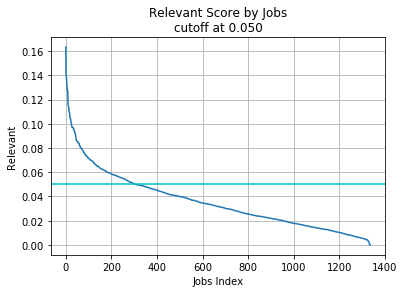

In [153]:
plt.plot(range(rel_jobs.shape[0]),rel_jobs.Relevant.values)
#set a cutoff at 0.050
plt.axhline(y=0.05, c='c')
plt.title('Relevant Score by Jobs\ncutoff at 0.050')
plt.ylabel("Relevant")
plt.xlabel('Jobs Index')
plt.grid(True)
plt.show()

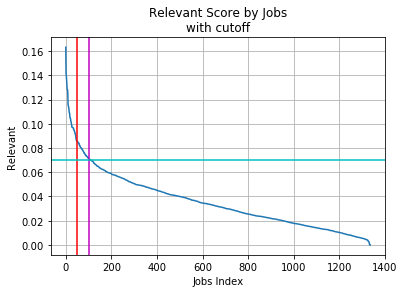

In [155]:
plt.plot(range(rel_jobs.shape[0]),rel_jobs.Relevant.values)
plt.title('Relevant Score by Jobs\nwith cutoff')
plt.ylabel("Relevant")
plt.xlabel('Jobs Index')
plt.axvline(x=100, c='m')
plt.axvline(x=50, c='r')
plt.axhline(y=0.07, c='c')
plt.grid(True)
plt.show()

### Look at the job titles between 50 and 100

In [109]:
for tit in rel_jobs[50:100].Short_Title:
    print(tit)

Data Science Instructor 
Data Scientist and Visualization Specialist 
Data Analyst and Data Scientist 
NASA SMAEC Data Scientist 
Data Scientist I 
Sr. Data Scientist(NLP) 
Data Scientist 
Data Analytics and Insights Specialist 
Data Scientist 
Data Scientist 
Jr. Data Scientist 
Data Scientist, Growth Data Science 
Associate Scientist, Data Science 
Senior Data Scientist 
Data Scientist 
Data Analyst 
Data Scientist / ML Engineer 
Sr. Data Scientist 
2019
Data Scientist 
Data Scientist 
Data Analyst 
Scientist I, Bioinformatics 
Manager, Data Science, Programming and Visualization 
Natural Language Processing Engineer 
Senior Machine Learning Engineer (NLP) 
Data Scientist, Applied Machine Learning 
Analytics, Retail Marketing Analyst 
Machine Learning Engineer (NLP) 
Data Engineer 
Physics Data Scientist 
Physics Data Scientist 
Data Scientist 
Data Science Software Engineer 
IT Data Scientist 
Data Scientist 
Data Scientist 
Full Time Opportunities for Students or Recent Graduates: 

In [111]:
for tit in rel_jobs[100:200].Short_Title:
    print(tit)

Data & Applied Scientist 
Senior Quantitative Modeler (San Francisco, CA) 
Data Scientist 
Data Engineer 
Statistical Analyst 
Research Scientist, Computational Genomics (Single Cell Characterization) 
Data Scientist 
Senior Data Visualization Scientist 
Data Scientist 
Natural Language Processing Scientist 
Director of Analytics 
Data Scientist, Engineering 
Senior Data Scientist 
Research Associate 
Data Scientist, Engineering 
Data Scientist 
A.I. Specialist 
Senior Data Analyst 
Data Analyst 
People Research Scientist, Internal Communications 
Data Engineer 
Data Science Intern 
Data Scientist 
Data Scientist I 
Data Scientist 
Data Scientist 
2020 Intern 
Sr Data Scientist (Analytic Consultant 5) 
Temporary Data Analyst and Visualization Specialist, Center for Digital and Data Excellence 
Data Scientist 
Senior Data Scientist 
Machine Learning Engineer 
Senior Consulting Data Analyst 
Data Scientist 
Data Scientist 
Associate Data Scientist 
AI & Data 
Big Data / PySpark Engineer 

### Still finding Data Scienist at 200'th relevant job

### Helper Functions for analysis

In [202]:
#takes a ver specific jobs dataframe looks for regex's in title 
#returns a percentage
def pct_rel(df):
    reg_rel = re.compile(r'Data (Scien|Analy)', flags=re.IGNORECASE)
    reg_irr = re.compile(r'\b(Manage)',flags=re.IGNORECASE)
    count = len([tit for tit in df.Short_Title 
                 if reg_rel.search(tit)
                 and not reg_irr.search(tit)])
    pct = (count / df.shape[0]) *100
    return pct

#Walks a df and calcs the percent relevant for a subset
#plots and returns

def rel_plot(df, avg=20):
    pct = []
    start = range(df.shape[0] - avg)
    for i in start:
        portion = df[i:i+avg]
        thispct = pct_rel(portion )
        pct.append(thispct)
        
    plt.plot(start, pct)
    plt.xlabel('Job Index')
    plt.ylabel('Pct Relevant')
    
#applies SVD to a matrix 
def reduce_dim(in_matrix, comp = 100,):
    svd = TruncatedSVD(n_components=comp)
    out_matrix = svd.fit_transform(in_matrix)
    return normalize(out_matrix)
    
#Applies MiniBatchKMeans repeatedly to estimate an elbow curve
#useful in estimating the appropriate number of clusters
def kmeans_elbow(matrix,kin=(1,50), title='MiniBatch KMeans'): 
    #inertia is the sum of squares to nearest neighbor
    ks = range(kin[0],kin[1])
    inert = [MiniBatchKMeans(k).fit(matrix).inertia_ for k in ks]
    
    plt.plot(ks, inert)
    plt.xlabel('Cluster Size (K)')
    plt.ylabel('Inertia - Sum of Squares between Clusters')
    plt.title(title)
    plt.show()
    
#Takes a TFIDF matrix and the bullet set, and the number of clusters to create
#returns a list of df each df containing a cluster of related jobs
def make_cluster_groups(matrix, blts,kin=15):
    model = KMeans(n_clusters=kin)
    clusters = model.fit_predict(matrix)
    out_df = pd.DataFrame({'Index':range(clusters.size),
                          'Cluster': clusters,
                          'Bullet': blts })
    return [cluster_df for _, cluster_df in out_df.groupby('Cluster')]

#takes the sorted set of bullets and returns the similarity matrix 
#note might ought to have the resume as bottom row for cosine similarity
def calc_blt_sim(texts, resume):
    aug_texts = texts + [resume]
    blt_vec = TfidfVectorizer(stop_words='english')
    sim_matrix1 = blt_vec.fit_transform(aug_texts)
    sim_matrix = sim_matrix1.toarray()
    return sim_matrix[:-1] @ sim_matrix[-1]

#takes a df containing a cluster
def calc_group_sim(cluster_df, blts, resume):
    ind = cluster_df.Index.values
    blt_sim = calc_blt_sim(blts, resume)
    return blt_sim[ind].mean()



#takes a list of df and sorts it by similarity to the resume

def sort_clusters(cluster_group):
    
    
    
    
    
    

In [118]:
pct = pct_rel(rel_jobs[100:200])
print(f"About {pct:.2f}% of jobs between 100 and 200 qualify")

About 65.00% of jobs between 100 and 200 qualify


In [119]:
pct = pct_rel(rel_jobs[200:300])
print(f"About {pct:.2f}% of jobs between 200 and 300 qualify")

About 58.00% of jobs between 200 and 300 qualify


In [121]:
pct = pct_rel(rel_jobs[0:100])
print(f"About {pct:.2f}% of jobs between 0 and 100 qualify")

About 76.00% of jobs between 0 and 100 qualify


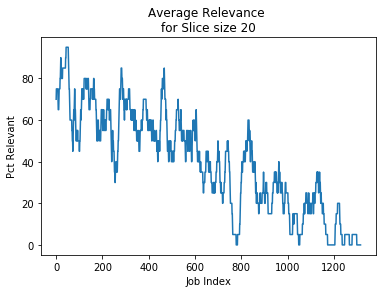

In [129]:
rel_plot(rel_jobs)
plt.title("Average Relevance \nfor Slice size 20")
plt.show()

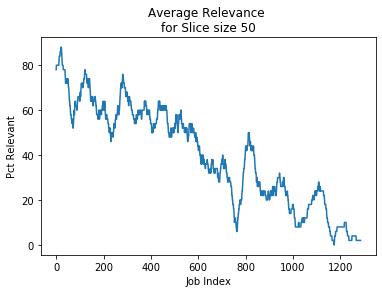

In [130]:
rel_plot(rel_jobs, avg=50)
plt.title("Average Relevance \nfor Slice size 50")
plt.show()

### Cluster Skills

Grab the Bullets for top 100 jobs

Make them into a data frame

In [132]:
top_blt = []
for blt in rel_jobs[:100].Bullets:
    top_blt.extend(blt)

In [133]:
bltdf = pd.DataFrame({'Bullets': top_blt})
print(bltdf.describe())

                                                  Bullets
count                                                1761
unique                                               1455
top     Processing, cleansing, and verifying the integ...
freq                                                    5


### Variables check

- top_blt is a list containing all words from bullets from the top 100 (Arbritary) jobs
- top_blt_set is a set with unique words from top_blt
- blt_matrix is the TFIDF matrix made from top_blt_set

In [134]:
top_blt_set = sorted(set(top_blt))
vec = TfidfVectorizer(stop_words='english')
blt_matrix =vec.fit_transform(top_blt_set)
print(blt_matrix.shape)

(1455, 2442)


### Shrink the matrix down some

default to 100 components

- small_blt_matrix is the dimension reduced blt_matrix

In [137]:
small_blt_matrix = reduce_dim(blt_matrix)
print(small_blt_matrix.shape)

(1455, 100)


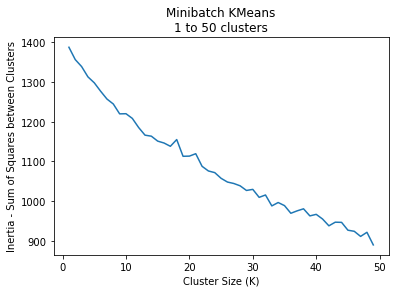

In [149]:
kmeans_elbow(small_blt_matrix,
             title='Minibatch KMeans\n1 to 50 clusters')

#### No elbow apparent at 50 clusters or less

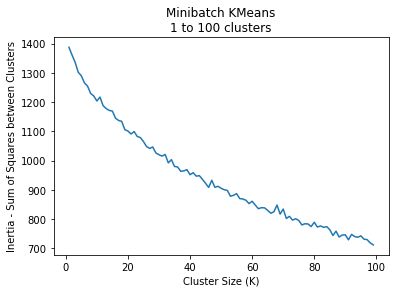

In [151]:
kmeans_elbow(small_blt_matrix, kin=(1,100),
             title='Minibatch KMeans\n1 to 100 clusters')

#### There is no obvious best cluster number in this dataset

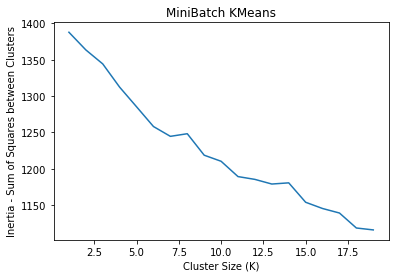

In [148]:
kmeans_elbow(small_blt_matrix, kin=(1,20))

### Clusters are created by  KMeans

clusters is a list of Pandas Dataframes

- clusters is a list of df each containing a cluster
- In this case they take the reduced TFIDF matrix and the set of unique words

In [162]:
clusters = make_cluster_groups(small_blt_matrix,top_blt_set)
clusters[0].head()

,Index,Cluster,Bullet
25,25,0,\nAble to work in a diverse R&D environment an...
27,27,0,\nActing as One fosters an environment of posi...
45,45,0,\nBecome expert on projects to help strategize...
53,53,0,"\nCan easily, effectively, and successfully wo..."
61,61,0,\nCollaborative team player.


### Wordcloud Helper Functions

In [193]:
#returns some color
def rand_color(*args,**kwargs):
    return np.random.choice([ 'blue', 'green','red',
                             'cyan','magenta','black'])

#takse a cluster df, a TFIDF matrix vec, the output 
#of the TFIDF vectorizer max is the number of words to present
def make_images(cluster_df, matrix, max=10, vec=vec):
    #the cluster_df is one of the list of clusters
    #Index is one of the df columns
    indices = cluster_df.Index.values
    sum_of_tfidf = np.asarray(matrix[indices].sum(axis=0))[0]
    input ={'Word': vec.get_feature_names(),'Sum TfIdf':sum_of_tfidf}
    words_df = pd.DataFrame(input).sort_values('Sum TfIdf', ascending=False)
    cloud_words = {word: score
                  for word, score in words_df[:max].values
                  if score != 0}
    clouder = WordCloud(background_color='white',
                       color_func= rand_color,
                       random_state=42)
    wc_image = clouder.fit_words(cloud_words)
    return wc_image


#Prints entries of random bullet values
def print_cluster(cluster_index,entries=10):
    work_cluster_df = clusters[cluster_index]
    for b in np.random.choice(work_cluster_df.Bullet.values,
                             entries,replace=False):
        print(b)
        
#Takes a list of df the TFIDF matrix, and number of rows and columns
#returns a grid of wordclouds printed 
def wc_grid(cluster_working, matrix, rows=5, cols=3, **kwargs):
    figure, axes = plt.subplots(rows, cols, figsize=(20,15))
    cluster_work_copy = cluster_working[:]
    for r in range(rows):
        for c in range(cols):
            if not cluster_work_copy: break
                
            if trace: print(r,c)
                
            #cluster_work_copy is a list of df.  popping gives a df
            cluster_df = cluster_work_copy.pop(0)
            wc_image = make_images(cluster_df, matrix,**kwargs)
            ax = axes[r][c]
            ax.imshow(wc_image, interpolation='bilinear')
            ax.set_title(f"Cluster {cluster_df.Cluster.iloc[0]}")
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()
            

        
        
        
        

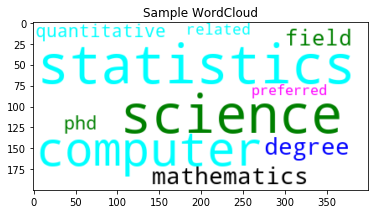


Currently has or is in the process of obtaining their BA/BS or Masters in Computer Science, Mathematics, Economics, Statistics, Applied Sciences like Biostatistics, Physics, Chemistry, Computational Neurology and or other quant-focused field
Advanced training in statistics (degree or continuing education)
Bachelorâs Degree in Statistics, GIS, Mathematics, Computer Science, Engineering or related fields, and 3+ years experience.
BS in Statistics, Mathematics, or a related field with 2+ years of experience
Bachelorâs or Masterâs degree in statistics, operations research, computer science, physics or related discipline


Pursuing a Bachelors or Masters in computer science, machine learning, data science, mathematics, statistics, or a related quantitative field.
BSc/BA in Computer Science, Engineering or relevant field; graduate degree in Data Science or other quantitative field is preferred
MS in Statistics, Machine Learning, Applied Physics or Computer Science (or technical degree

In [199]:
acluster = 4
wc = make_images(clusters[acluster],blt_matrix)
plt.imshow(wc, interpolation='bilinear')
plt.title('Sample WordCloud')
plt.show()
print_cluster(acluster)

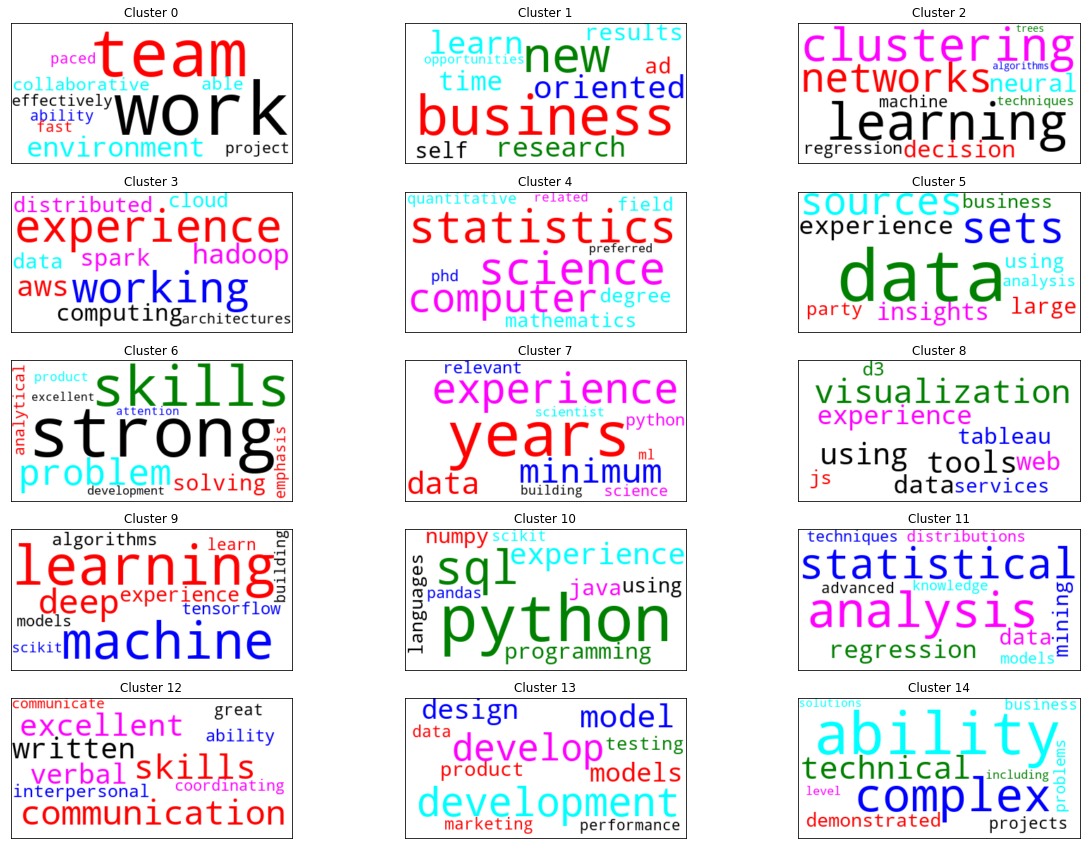

In [194]:
wc_grid(clusters,blt_matrix)

### Explore the similaity of each of the clusters to the resume

- blt_sim is the cosine similarity vector for a cluster
- calc_group_sim() computes the group similarity

In [252]:
blt_sim = calc_blt_sim(top_blt_set, resume)

In [256]:
tech_sim = calc_group_sim(clusters[8],top_blt_set, resume)
print(tech_sim)
soft_sim = calc_group_sim(clusters[14],top_blt_set, resume)
print(soft_sim)

0.10087431821651227
0.008840619644705394


### Calculate the  similarity for each of the clusters

In [253]:
sim_score ={}
for i in range(len(clusters)):
    ascore  = calc_group_sim(clusters[i],top_blt_set, resume)
    sim_score[i] = ascore
    print(f"Cluster {i} has a similarity score {ascore:.3f}")
    

Cluster 0 has a similarity score 0.006
Cluster 1 has a similarity score 0.013
Cluster 2 has a similarity score 0.089
Cluster 3 has a similarity score 0.012
Cluster 4 has a similarity score 0.008
Cluster 5 has a similarity score 0.033
Cluster 6 has a similarity score 0.018
Cluster 7 has a similarity score 0.032
Cluster 8 has a similarity score 0.101
Cluster 9 has a similarity score 0.058
Cluster 10 has a similarity score 0.095
Cluster 11 has a similarity score 0.086
Cluster 12 has a similarity score 0.019
Cluster 13 has a similarity score 0.019
Cluster 14 has a similarity score 0.009


### Sort the similarity scores

sorted returns a list of tuples

In [254]:
sorted_sim_score = sorted(sim_score.items(),
                          key=lambda x:x[1], reverse=True)


### Apply the sorted sim scores to produce word clouds in order

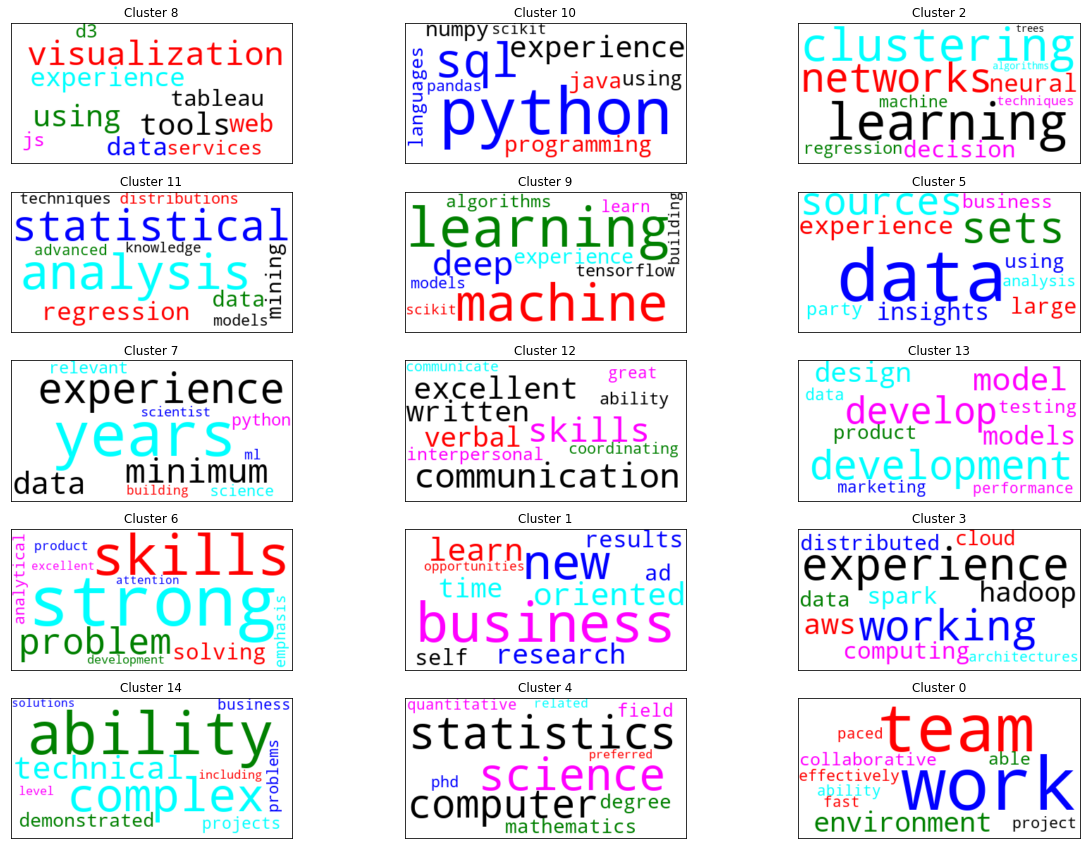

In [237]:
sorted_clusters = []

for i in range (len(clusters)):
    sorted_clusters.append(clusters[sorted_sim_score[i][0]])
    
wc_grid(sorted_clusters,blt_matrix)  

### Print some of the bullets for each of the clusters

In [251]:
for i in range(len(sorted_clusters)):
    print(f"\n Cluster {sorted_sim_score[i][0]}:" )
    print_cluster(sorted_sim_score[i][0])


 Cluster 8:

Hands on experience in designing data as a service using REST APIs
Proficiency in data exploration techniques and tools, e.g. SQL, Hive, etc.


Visualization: Tableau or similar
The ideal candidate will have experience with Big Data, document processing with Apache Tika, and also experience building topic modeling, and information processing pipelines. Experience building dynamic web services using React.js is a plus. Some web development experience including Bootstrap, HTML, CSS, JavaScript is desired.
Experience using web services: Redshift, S3, Spark, DigitalOcean, etc

Experience with data visualization tools ex Tableau

Experience in data visualization using Power BI, Tableau, D3.js, Qlik Sense, HTML/JavaScript is a plus
Experience in basic visualization methods, especially using tools such as Tableau, ggplot, and matplotlib. Further credit will be given to those with experience making interactive reports in R and Python or dashboards in Tableau or other government f

### Set the analysis to run with different numbers of clusters

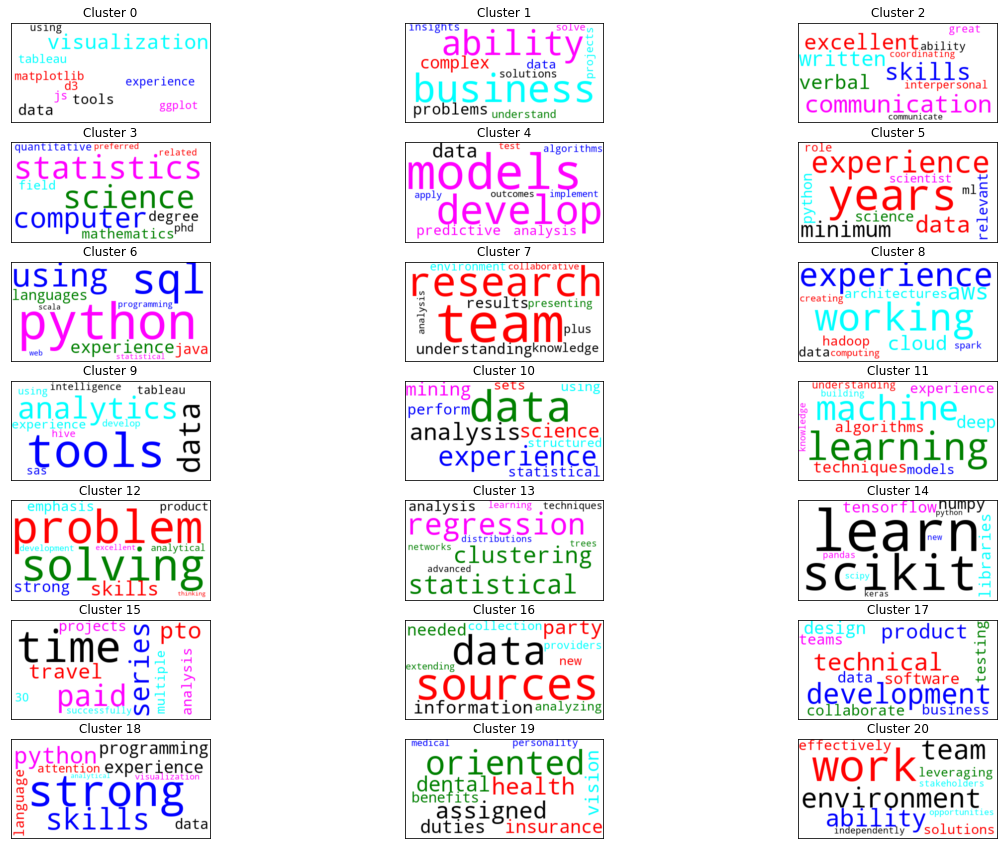

In [257]:
nbr_cluster = 21

clusters21 = make_cluster_groups(small_blt_matrix,
                               top_blt_set,
                               kin=nbr_cluster)

wc_grid(clusters21,blt_matrix,rows=7,cols=3)

Cluster 0 has a similarity score 0.117
Cluster 1 has a similarity score 0.018
Cluster 2 has a similarity score 0.019
Cluster 3 has a similarity score 0.008
Cluster 4 has a similarity score 0.034
Cluster 5 has a similarity score 0.029
Cluster 6 has a similarity score 0.081
Cluster 7 has a similarity score 0.011
Cluster 8 has a similarity score 0.013
Cluster 9 has a similarity score 0.039
Cluster 10 has a similarity score 0.041
Cluster 11 has a similarity score 0.045
Cluster 12 has a similarity score 0.017
Cluster 13 has a similarity score 0.102
Cluster 14 has a similarity score 0.137
Cluster 15 has a similarity score 0.016
Cluster 16 has a similarity score 0.013
Cluster 17 has a similarity score 0.012
Cluster 18 has a similarity score 0.024
Cluster 19 has a similarity score 0.005
Cluster 20 has a similarity score 0.008


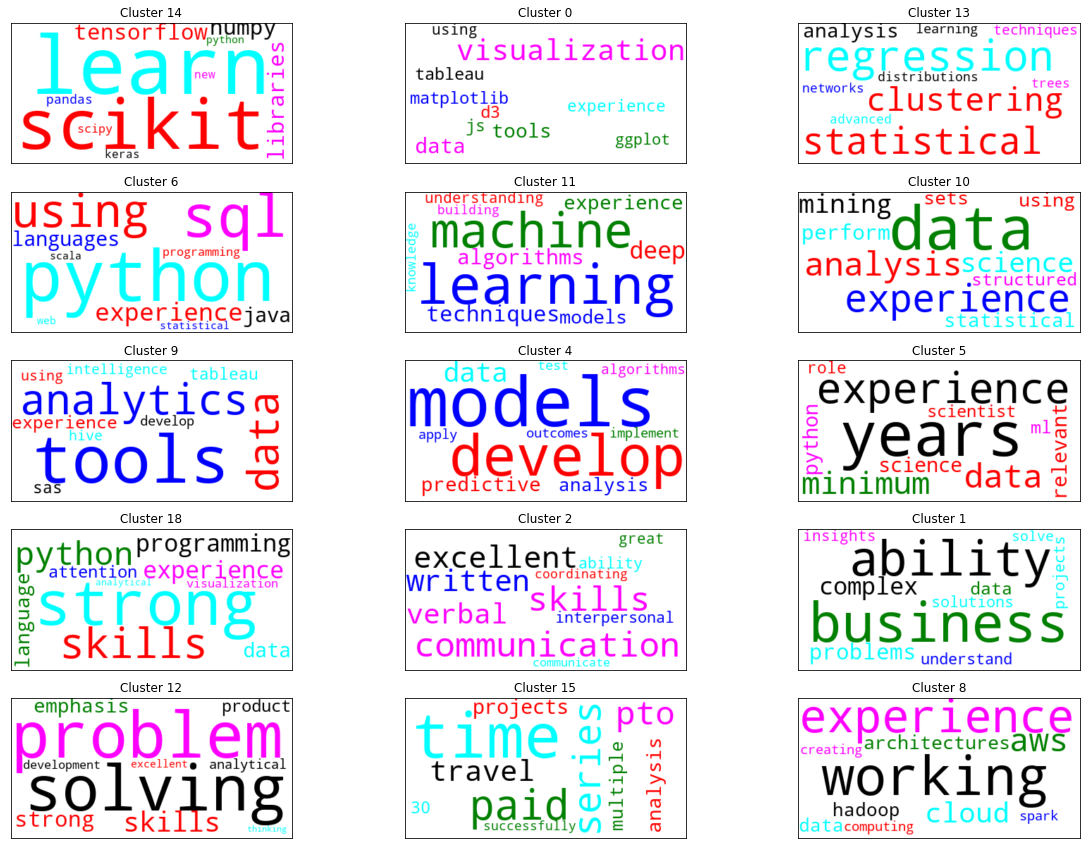

In [258]:
sim_score21 ={}
for i in range(len(clusters21)):
    ascore  = calc_group_sim(clusters21[i],top_blt_set, resume)
    sim_score21[i] = ascore
    print(f"Cluster {i} has a similarity score {ascore:.3f}")
    
sorted_sim_score21 = sorted(sim_score21.items(),
                          key=lambda x:x[1], reverse=True)


sorted_clusters21 = []

for i in range (len(clusters21)):
    sorted_clusters21.append(clusters21[sorted_sim_score21[i][0]])
    
wc_grid(sorted_clusters21,blt_matrix)  